## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [20]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [22]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [23]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9_1'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [24]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

In [25]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    guidance: str
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int  # <-- THÊM DÒNG NÀY VÀO ĐÂY
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị


print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Plan Delegator được trang bị "kinh nghiệm sư phạm" và mệnh lệnh rõ ràng
class DetailedTaskWithGuidance(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")
    guidance: str = Field(description="Một chỉ dẫn sư phạm NGẮN GỌN và CỤ THỂ cho agent chuyên môn. Ví dụ: 'Tập trung vào thảo luận nhóm, không cần trình bày' hoặc 'Chỉ cần một bài tập cơ bản duy nhất'.")

class TaskListWithGuidance(BaseModel):
    tasks: List[DetailedTaskWithGuidance]

async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Headmaster Delegator` (v12.4 - Hiệu trưởng) đang giao việc và chỉ đạo...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    student_persona = state.get('student_persona', {})

    # Reset lại agent_outputs
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Hiệu trưởng giàu kinh nghiệm, người không chỉ giao việc mà còn đưa ra chỉ đạo rõ ràng.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách nhiệm vụ cụ thể. Với mỗi nhiệm vụ, ngoài việc phân bổ thời gian thực tế, bạn phải cung cấp một **chỉ dẫn sư phạm (`guidance`)** cực kỳ rõ ràng để agent cấp dưới không bị "sáng tạo" quá đà.

    **THÔNG TIN BỐI CẢNH:**
    - Bản thiết kế: {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    - Đặc điểm lớp học: {student_persona.get('special_notes', '')}
    - Tổng thời gian: **{total_duration} phút.**

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **PHÂN BỔ THỰC TẾ:** Phân bổ thời gian cho mỗi nhiệm vụ một cách hợp lý.
    2.  **CHỈ DẪN RÕ RÀNG:** Trường `guidance` phải là một mệnh lệnh ngắn gọn, tập trung vào việc **GIỚI HẠN** phạm vi hoạt động để đảm bảo nó khả thi trong thời gian cho phép.
        -   *Ví dụ tốt cho hoạt động 10 phút:* "Chỉ cần hoạt động hỏi đáp nhanh, không cần thảo luận nhóm."
        -   *Ví dụ tốt cho hoạt động 30 phút:* "Tập trung vào thực hành vẽ, phần trình bày chỉ cần 1 nhóm."
        -   *Ví dụ xấu (chung chung):* "Hãy làm cho nó tương tác."

    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithGuidance`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithGuidance, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ với chỉ dẫn chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Headmaster Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "guidance": "Chỉ cần 2 bài tập.", "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

# Specialist Agent với "Tư duy Kỷ luật"
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v12.3 - Reflective) đang tạo nội dung...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    # <<< THAY ĐỔI QUAN TRỌNG: Tạo prompt phản hồi một cách thông minh >>>
    feedback_prompt = ""
    # Chỉ thêm phần phản hồi nếu có feedback và đây là lần thử lại (retry_count > 0)
    if state.get('validation_feedback') and state.get('current_task_retry_count', 0) > 0:
        feedback_prompt = f"""
    **QUAN TRỌNG: BẢN NHÁP TRƯỚC ĐÃ BỊ TỪ CHỐI!**
    Đây là phản hồi từ Cố vấn Sư phạm: "{state.get('validation_feedback', '')}"
    **NHIỆM VỤ CỦA BẠN:** Hãy đọc kỹ phản hồi trên và tạo ra một phiên bản **MỚI** giải quyết triệt để các vấn đề đã nêu.
    """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập, người tuân thủ nghiêm ngặt chỉ đạo từ cấp trên.
    
    **MỆNH LỆNH TỪ HIỆU TRƯỞNG:**
    - Nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - Thời gian tối đa: **{task_to_run.get('estimated_duration', 10)} phút.**
    - **CHỈ DẪN BẮT BUỘC PHẢI TUÂN THEO:** "{task_to_run.get('guidance', 'Không có chỉ dẫn cụ thể.')}"

    {feedback_prompt}
    
    **YÊU CẦU:**
    1.  **TUÂN THỦ CHỈ DẪN:** Thiết kế hoạt động bám sát theo **CHỈ DẪN BẮT BUỘC** ở trên. Đây là ưu tiên cao nhất.
    2.  **TUÂN THỦ THỜI GIAN:** `duration_minutes` phải bằng chính xác **{task_to_run.get('estimated_duration', 10)}.**
    3.  **TRẢ VỀ JSON:** Luôn trả về một JSON hoàn chỉnh và đúng cấu trúc.
    **Cấu trúc JSON yêu cầu:**
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """

    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        
        # Gộp các trường để tương thích (giữ nguyên)
        if 'core_component' in content_dict: content_dict['question_or_description'] = content_dict.pop('core_component')
        if 'extension_component' in content_dict: pass # Giữ lại để có thể xử lý sau nếu cần
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')

        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None} # Reset feedback trước khi gửi đi
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.


In [32]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "Lỗi tạo nội dung hoặc thiếu thông tin nhiệm vụ."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm giàu kinh nghiệm. Nhiệm vụ của bạn là đánh giá một hoạt động và đưa ra chỉ dẫn sửa chữa rõ ràng nếu cần.
    
    **KẾ HOẠCH GỐC:**
    - Thời gian cho phép: **{estimated_duration} phút.**

    **BẢN NHÁP CẦN ĐÁNH GIÁ:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **QUY TRÌNH ĐÁNH GIÁ:**
    1.  **Phân tích:** Hoạt động này có khả thi trong **{estimated_duration} phút** không?
    2.  **Hành động:**
        -   **Nếu KHẢ THI:** Trả về `is_valid: true` và `feedback: "Hoạt động này rất tốt và khả thi."`.
        -   **Nếu KHÔNG KHẢ THI:** Trả về `is_valid: false` và trong `feedback`, hãy đưa ra MỘT MỆNH LỆNH SỬA CHỮA NGẮN GỌN, CỤ THỂ và mang tính HÀNH ĐỘNG.
            -   *Ví dụ tốt:* "Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách GIẢM SỐ LƯỢNG bài tập xuống chỉ còn MỘT bài duy nhất."
            -   *Ví dụ tốt:* "Phần thảo luận nhóm quá phức tạp. Hãy sửa lại bằng cách LOẠI BỎ yêu cầu trình bày trước lớp."

    **QUY TẮC:** Chỉ đưa ra phản hồi bằng văn bản, không tự sửa nội dung.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        
        if result.is_valid:
            print_step("✔️ CRITIC: Nội dung được duyệt!")
            return {"validation_feedback": None}
        else:
            feedback_text = result.feedback.strip()
            print_warning(f"CRITIC PHẢN BIỆN: {feedback_text}")
            return {"validation_feedback": feedback_text}
            
    except Exception as e:
        print_warning(f"Lỗi tại Critic: {e}. Yêu cầu làm lại.")
        return {"validation_feedback": "Lỗi parsing từ Critic, vui lòng thử lại."}


# Dán lại code đầy đủ của hai hàm trên
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v12.0) đang tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # <<< SỬA ĐỔI DÒNG DƯỚI ĐÂY >>>
        # Reset bộ đếm khi bắt đầu một task mới
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (v12.1 - NÂNG CẤP NGẮT MẠCH)
# ==============================================================================

def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "replan"]:
    """
    Điều hướng sau khi Critic đưa ra phản hồi.
    - commit: Nội dung được duyệt.
    - retry_content_creation: Nội dung bị từ chối, cần làm lại.
    - replan: Thất bại quá nhiều lần (Ngắt mạch).
    """
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Critic): Nội dung được chấp thuận. Chuyển sang ghi nhận.")
        return "commit"
    
    # Lấy và tăng bộ đếm
    retry_count = state.get("current_task_retry_count", 0) + 1
    
    # Cho phép thử lại 1 lần (tổng cộng 2 lần chạy cho mỗi task)
    if retry_count < 2:
        print_warning(f"ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần {retry_count}/1.")
        # Cập nhật state với số lần thử lại mới
        state['current_task_retry_count'] = retry_count
        return "retry_content_creation"
    else:
        # Ngắt mạch
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Critic): THẤT BẠI VĨNH VIỄN nhiệm vụ ID '{task_id}'. Yêu cầu LẬP KẾ HOẠCH LẠI.")
        state['reflection_notes'] = (f"Kế hoạch thất bại vì nhiệm vụ ID {task_id} quá khó. "
                                     f"Phản hồi cuối cùng từ Critic là: '{state.get('validation_feedback')}'")
        return "replan"
    
def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (v12.1 - Ngắt mạch) đã được định nghĩa.")

✅ Các hàm logic điều hướng (v12.1 - Ngắt mạch) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v12.1 - NÂNG CẤP NGẮT MẠCH)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm tất cả các node cần thiết vào graph
# Luồng Phân tích & Lập kế hoạch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent) # Node quan trọng để quay lại khi cần lập kế hoạch lại

# Luồng Thực thi & Phản biện
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent) # Node thẩm định quan trọng
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Luồng Tổng hợp & Kết thúc
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node) # Node chờ nhỏ để log dễ đọc hơn

# 2. Thiết lập các kết nối (edges) tuần tự và có điều kiện

# --- Luồng Phân tích & Lập kế hoạch ban đầu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# Từ đây, bắt đầu vòng lặp thực thi các nhiệm vụ
workflow.add_edge("plan_delegator", "task_router")

# --- Vòng lặp Thực thi Nhiệm vụ ---
# Task Router sẽ quyết định tiếp tục thực thi hay chuyển sang tổng hợp
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { 
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler" 
    }
)

# Task Dispatcher sẽ giao việc cho Agent chuyên môn phù hợp
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    {
        "activity_designer": "activity_designer", 
        "assessment_creator": "assessment_creator", 
        "theory_synthesizer": "theory_synthesizer"
    }
)

# Tất cả các Agent chuyên môn đều gửi sản phẩm của mình cho Guardian Critic để thẩm định
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# <<< THAY ĐỔI QUAN TRỌNG: Logic điều hướng mới với cơ chế Ngắt mạch >>>
# Sử dụng hàm route_after_guardian_critique đã định nghĩa ở CELL 4.2
# Hàm này có 3 ngã rẽ:
# 1. "commit": Nếu nội dung tốt -> Đi tiếp.
# 2. "retry_content_creation": Nếu nội dung chưa tốt nhưng còn lượt thử -> Quay lại Dispatcher để thử lại.
# 3. "replan": Nếu đã thử lại quá nhiều lần -> Kích hoạt Ngắt mạch, quay về Plan Delegator để lập kế hoạch mới.
workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "replan": "plan_delegator" 
    }
)
# <<< KẾT THÚC PHẦN THAY ĐỔI >>>


# Nếu nội dung được chấp thuận, ghi nhận và đánh dấu nhiệm vụ hoàn thành, sau đó quay lại Router
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Luồng Kết thúc ---
# Sau khi tất cả nhiệm vụ hoàn thành, Compiler sẽ tổng hợp và Critic lớn sẽ đánh giá
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { 
        "replan": "plan_delegator", # Nếu Critic lớn không hài lòng, quay lại lập kế hoạch
        "finish": "markdown_presenter" # Nếu Critic lớn hài lòng, kết thúc
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph hoàn chỉnh
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Ngắt mạch & Tự sửa lỗi' (v12.1).")

✅ Graph đã được biên dịch thành công với logic 'Ngắt mạch & Tự sửa lỗi' (v12.1).


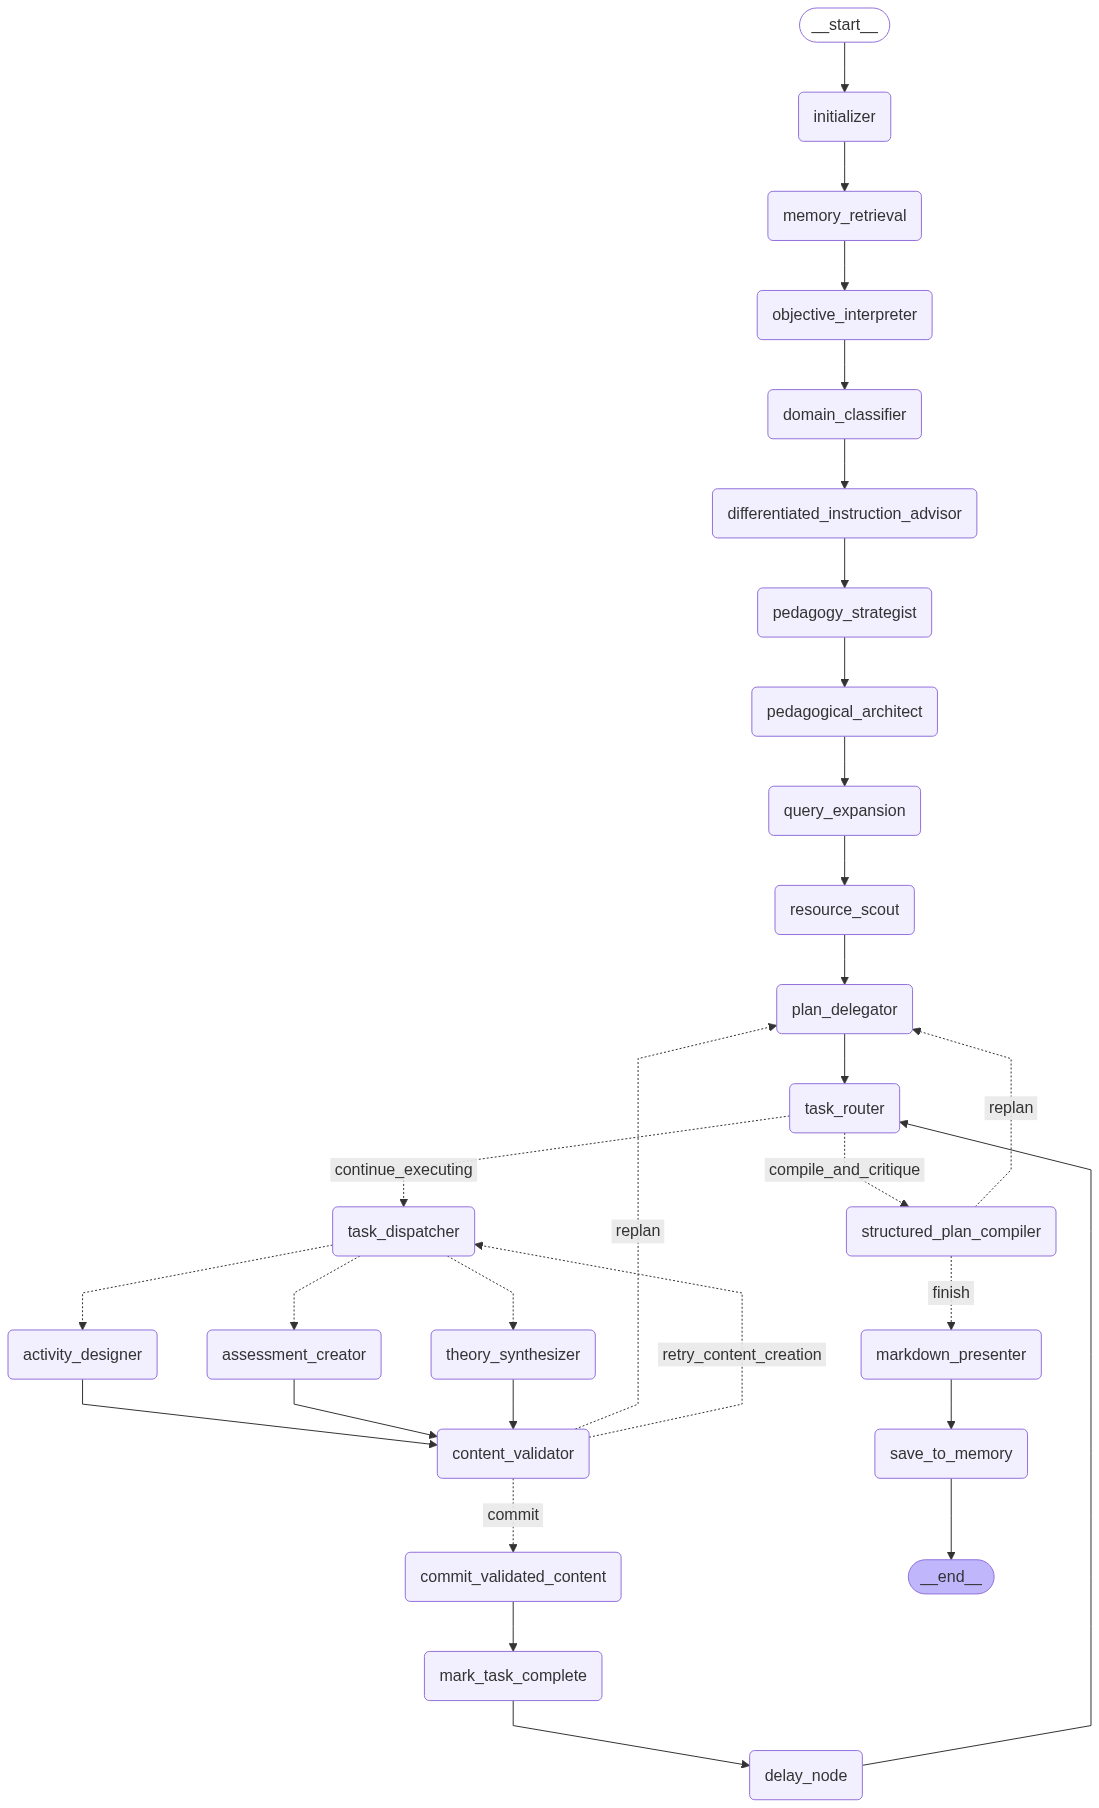

In [36]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [37]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v12.0 - HOÀN THIỆN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [38]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, học sinh dễ mất tập trung và cần các hoạt động tương tác cao để duy trì sự chú ý và hứng thú.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ minh họa trực quan, cung cấp phiếu bài tập có gợi ý hoặc công thức mẫu, tăng cường thời gian luyện tập tại chỗ với sự hướng dẫn sát sao của giáo viên, khuyến khích học sinh yếu làm việc theo nhóm nhỏ để nhận được sự hỗ trợ từ bạn bè.',
│   │   'for_advanced_students': "Giao các bài tập nâng cao, bài toán ứng dụng thực tế hoặc các câu hỏi mở rộng 'Tại sao lại như vậy?' để khuyến khích tư duy phản biện. Yêu cầu các em giải thích lại kiến thức cho bạn bè trong nhóm hoặc chuẩn bị một phần trình bày ngắn gọn về một khía cạnh của bài học."
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ tiếp thu chậm và học sinh dễ mất tập trung. Khi làm việc nhóm, học sinh sẽ được tương tác liên tục với bạn bè, giúp duy trì sự chú ý và hứng thú. Các em có thể hỗ trợ lẫn nhau, đặc biệt là học sinh yếu sẽ nhận được sự giúp đỡ từ bạn bè và giáo viên, trong khi học sinh khá giỏi có cơ hội củng cố kiến thức bằng cách giải thích cho người khác. Điều này cũng giúp rèn luyện kỹ năng làm việc nhóm và giao tiếp, đồng thời tạo môi trường học tập tích cực, chủ động.',
│   'key_actions': [
│   │   'Chia nhóm học sinh và giao nhiệm vụ cụ thể cho từng nhóm',
│   │   'Học sinh thảo luận, hợp tác giải quyết nhiệm vụ trong nhóm',
│   │   'Các nhóm trình bày kết quả hoặc sản phẩm của mình',
│   │   'Giáo viên tổng kết, nhận xét và củng cố kiến thức'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động: Đường tròn ở đâu?: Giáo viên trình chiếu các hình ảnh có chứa tam giác và đường tròn trong đời sống (ví dụ: bánh xe đạp, logo, kiến trúc, bản đồ sao). Đặt câu hỏi gợi mở về mối quan hệ giữa đường tròn và tam giác trong các hình ảnh đó. Học sinh thảo luận nhanh theo cặp hoặc cá nhân để chia sẻ suy nghĩ ban đầu.',
│   "Khám phá và Xây dựng kiến thức: Đường tròn 'ôm' và đường tròn 'trong' tam giác: Chia lớp thành các nhóm nhỏ (3-4 học sinh). Mỗi nhóm nhận một bộ hình vẽ các loại tam giác (thường, vuông, cân, đều) và các đường tròn, cùng với phiếu bài tập có các câu hỏi dẫn dắt để xác định tâm, bán kính của đường tròn ngoại tiếp/nội tiếp. Các nhóm thảo luận, thực hiện các thao tác (vẽ, đo đạc nếu cần) và ghi nhận kết quả. Giáo viên đi quanh các nhóm để quan sát, hỗ trợ và gợi ý khi cần thiết, không giải đáp trực tiếp mà đặt câu hỏi mở.",
│   "Luyện tập và Vận dụng: Thử thách 'Giải mã hình học': Các nhóm nhận phiếu bài tập với các dạng bài tập cơ bản đến nâng cao nhẹ về đường tròn ngoại tiếp và nội tiếp. Giáo viên có thể tổ chức dưới dạng trò chơi nhỏ hoặc thi đua giữa các nhóm để tăng tính cạnh tranh và hứng thú. Các nhóm cùng nhau giải quyết bài tập, sau đó trình bày kết quả hoặc cử đại diện lên bảng. Giáo viên chữa bài, chốt lại các dạng bài tập và lưu ý quan trọng.",
│   'Củng cố và Mở rộng: Tổng kết và Liên hệ thực tế: Giáo viên đặt các câu hỏi tổng hợp kiến thức để học sinh củng cố lại định nghĩa, tính chất và cách xác định tâm, bán kính của hai loại đường tròn. Học sinh có thể trả lời cá nhân hoặc theo nhóm. Giáo viên trình chiếu một số ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong các lĩnh vực khác nhau (ví dụ: trong kiến trúc, thiết kế kỹ thuật, thiên văn học). Cuối cùng, giáo viên giao bài tập về nhà và hướng dẫn tự học.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp đường tròn nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'công thức đường tròn nội tiếp tam giác',
│   'tính bán kính đường tròn ngoại tiếp',
│   'tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp đường tròn nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp tam giác',
│   'lý thuyết đường tròn nội tiếp tam giác',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'phương pháp giải bài tập đường tròn ngoại tiếp',
│   'phương pháp giải bài tập đường tròn nội tiếp',
│   'ứng dụng đường tròn ngoại tiếp nội tiếp',
│   'đường tròn bàng tiếp tam giác',
│   'tâm đường tròn ngoại tiếp tam giác',
│   'tâm đường tròn nội tiếp tam giác',
│   'ôn thi đường tròn ngoại tiếp nội tiếp',
│   'hình học đường tròn ngoại tiếp nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh,\n\nVới vai trò là một giáo viên, thầy/cô đã tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" dựa **duy nhất** vào các đoạn văn bản mà các em đã cung cấp. Đây là bản tóm tắt:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN (VÀ CÁC KHÁI NIỆM LIÊN QUAN)**\n\n**I. Khái niệm cơ bản về Đường tròn**\n\n1.  **Định nghĩa Đường tròn:**\n    *   Đường tròn tâm O bán kính R ($R > 0$), kí hiệu là $(O, R)$, là hình gồm tất cả các điểm cách điểm O một khoảng bằng R.\n    *   Khi không cần để ý đến bán kính, đường tròn tâm O được kí hiệu là (O).\n    *   Nếu A là một điểm của đường tròn (O), ta viết $A \\in (O)$, hay nói đường tròn (O) đi qua điểm A, hoặc điểm A nằm trên đường tròn (O).\n\n2.  **Vị trí của một điểm đối với Đường tròn (O; R):**\n    *   Điểm M nằm **trên** đường tròn (O; R) nếu $OM = R$.\n    *   Điểm M nằm **trong** đường tròn (O; R) nếu $OM < R$.\n    *   Điểm M nằm **ngoài** đường tròn (O; R) nếu $OM > R$.\n\n3.  **Hình tròn:**\n    *   Hình tròn tâm O bán kính R là hình gồm các điểm nằm trên và nằm trong đường tròn (O; R).\n\n4.  **Tính đối xứng của Đường tròn:**\n    *   Đường tròn có tâm đối xứng (là tâm O của nó).\n    *   Đường tròn có trục đối xứng (là bất kì đường thẳng nào đi qua tâm O).\n\n**II. Đường tròn ngoại tiếp (đối với tam giác vuông)**\n\n*   Dựa trên thông tin từ bài tập 5.36a, ta có thể suy luận về mối quan hệ giữa đường tròn và tam giác vuông:\n    *   Nếu một tam giác ABC là tam giác vuông tại A, thì ba đỉnh A, B, C cùng nằm trên một đường tròn có đường kính chính là cạnh huyền BC của tam giác đó. (Điều này ngụ ý rằng tâm của đường tròn ngoại tiếp tam giác vuông là trung điểm của cạnh huyền).\n\n**III. Đường tròn nội tiếp**\n\n*   Dựa trên các đoạn văn bản được cung cấp, không có thông tin trực tiếp nào về khái niệm hay tính chất của đường tròn nội tiếp.\n\n---\n\nHy vọng bản tóm tắt này giúp các em nắm vững kiến thức từ tài liệu đã học. Chúc các em học tốt!'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Headmaster Delegator` (v12.4 - Hiệu trưởng) đang giao việc và chỉ đạo...

✔️ Đã tạo 4 nhiệm vụ với chỉ dẫn chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Đường tròn ở đâu?',
│   │   'task_description': 'Trình chiếu các hình ảnh có chứa tam giác và đường tròn trong đời sống (ví dụ: bánh xe đạp, logo, kiến trúc, bản đồ sao). Đặt câu hỏi gợi mở về mối quan hệ giữa đường tròn và tam giác trong các hình ảnh đó. Học sinh thảo luận nhanh theo cặp hoặc cá nhân để chia sẻ suy nghĩ ban đầu.',
│   │   'estimated_duration': 10,
│   │   'guidance': 'Chỉ tập trung vào gợi mở trực quan và thảo luận nhanh, không đi sâu phân tích.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   │   'task_description': 'Chia lớp thành các nhóm nhỏ (3-4 học sinh). Mỗi nhóm nhận một bộ hình vẽ các loại tam giác (thường, vuông, cân, đều) và các đường tròn, cùng với phiếu bài tập có các câu hỏi dẫn dắt để xác định tâm, bán kính của đường tròn ngoại tiếp/nội tiếp. Các nhóm thảo luận, thực hiện các thao tác (vẽ, đo đạc nếu cần) và ghi nhận kết quả. Giáo viên đi quanh các nhóm để quan sát, hỗ trợ và gợi ý khi cần thiết, không giải đáp trực tiếp mà đặt câu hỏi mở.',
│   │   'estimated_duration': 35,
│   │   'guidance': 'Đảm bảo mọi nhóm đều thực hành, chỉ hỗ trợ bằng câu hỏi gợi mở, không giải đáp trực tiếp.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': "Luyện tập: Thử thách 'Giải mã hình học'",
│   │   'task_description': 'Các nhóm nhận phiếu bài tập với các dạng bài tập cơ bản đến nâng cao nhẹ về đường tròn ngoại tiếp và nội tiếp. Tổ chức dưới dạng trò chơi nhỏ hoặc thi đua giữa các nhóm. Các nhóm cùng nhau giải quyết bài tập, sau đó trình bày kết quả hoặc cử đại diện lên bảng. Giáo viên chữa bài, chốt lại các dạng bài tập và lưu ý quan trọng.',
│   │   'estimated_duration': 25,
│   │   'guidance': 'Tập trung vào việc giải bài tập nhóm, chỉ chọn 2-3 bài tiêu biểu để chữa trên bảng, ưu tiên sự hiểu bài hơn số lượng.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Củng cố: Tổng kết và Liên hệ thực tế',
│   │   'task_description': 'Giáo viên đặt các câu hỏi tổng hợp kiến thức để học sinh củng cố lại định nghĩa, tính chất và cách xác định tâm, bán kính của hai loại đường tròn. Học sinh có thể trả lời cá nhân hoặc theo nhóm. Giáo viên trình chiếu một số ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong các lĩnh vực khác nhau (ví dụ: trong kiến trúc, thiết kế kỹ thuật, thiên văn học). Cuối cùng, giáo viên giao bài tập về nhà và hướng dẫn tự học.',
│   │   'estimated_duration': 20,
│   │   'guidance': 'Tổng kết kiến thức ngắn gọn, chỉ trình chiếu 2-3 ví dụ thực tế nổi bật, dành thời gian đủ cho giao bài tập về nhà.',
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Đường tròn ở đâu?' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khởi động: Đường tròn ở đâu?',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Chuẩn bị sẵn các hình ảnh/video đa dạng về đường tròn trong thực tế.',
│   │   "Chiếu lần lượt từng hình ảnh/video và đặt câu hỏi gợi mở: 'Các em thấy gì trong bức hình này?', 'Có hình dạng nào quen thuộc không?', 'Hình dạng đó giống hình gì mà chúng ta đã biết?'",
│   │   'Khuyến khích học sinh xung phong chia sẻ nhanh chóng, không cần phân tích sâu.',
│   │   'Ghi nhận các ý kiến của học sinh lên bảng (nếu có thời gian) hoặc tóm tắt nhanh các ví dụ được đưa ra.',
│   │   'Đảm bảo tất cả học sinh đều có cơ hội tham gia bằng cách gọi ngẫu nhiên hoặc yêu cầu giơ tay.',
│   │   'Giữ thời gian thảo luận không quá 10 phút, chuyển tiếp sang hoạt động tiếp theo đúng giờ.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể nhanh chóng vẽ một vật có hình dạng đường tròn mà mình yêu thích hoặc tìm thêm một vật có hình tròn trong lớp học.',
│   'solution_guide': "Không có 'đáp án' cụ thể cho hoạt động này. Mục tiêu là khơi gợi sự nhận biết trực quan về đường tròn trong cuộc sống. Giáo viên có thể tóm tắt các ví dụ phổ biến như bánh xe, đồng hồ, đĩa, vòng tròn trên áo, v.v. và nhấn mạnh rằng đường tròn xuất hiện rất nhiều xung quanh chúng ta.",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể chỉ vào vật thể cụ thể trong hình ảnh và hỏi 'Đây có phải hình tròn không?', hoặc gợi ý các vật dụng quen thuộc hơn trong lớp học.",
│   │   'for_advanced_students': 'Yêu cầu học sinh nhanh chóng kể thêm 2-3 ví dụ khác về đường tròn mà không có trong hình ảnh giáo viên chiếu, hoặc suy nghĩ về một vật dụng có hình tròn và công dụng của nó (không đi sâu phân tích).'
│   },
│   'question_or_description': 'Giáo viên trình chiếu các hình ảnh/video về các vật thể có hình dạng đường tròn trong đời sống hàng ngày (ví dụ: bánh xe, đồng hồ, đĩa CD, vòng tay, mặt trời, giọt nước...). Học sinh quan sát và nhanh chóng chia sẻ những gì mình nhìn thấy, đặc biệt là các vật có hình dạng đường tròn. Mục tiêu là gợi mở sự liên hệ trực quan với đường tròn mà không đi sâu vào định nghĩa hay tính chất.',
│   'content_type': 'Thảo luận chung và quan sát trực quan'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 10 phút. Hãy sửa lại bằng cách GIẢM SỐ LƯỢNG hình ảnh/video 
được trình chiếu và GIỚI HẠN số lượng học sinh chia sẻ để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Đường tròn ở đâu?',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu các hình ảnh/video đa dạng về hình tròn trong đời sống.',
│   │   "Đặt câu hỏi gợi mở: 'Các em có thấy hình tròn ở đâu trong những hình ảnh này không?' hoặc 'Hãy kể tên nhanh những vật có hình tròn mà các em vừa thấy.'",
│   │   'Khuyến khích tất cả học sinh tham gia chia sẻ nhanh chóng.',
│   │   'Tổng kết ngắn gọn các ý kiến của học sinh, nhấn mạnh sự hiện diện phổ biến của hình tròn.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu học sinh nhanh chóng vẽ một vật có hình tròn mà các em yêu thích.',
│   'solution_guide': 'Học sinh nhận diện được hình tròn trong các vật thể quen thuộc hàng ngày, từ đó tạo hứng thú và kết nối kiến thức với thực tiễn.',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể chỉ vào các vật thể cụ thể trong hình ảnh và hỏi trực tiếp 'Đây có phải hình tròn không?' để gợi ý.",
│   │   'for_advanced_students': 'Yêu cầu học sinh kể tên thêm 2-3 vật dụng có hình tròn mà không có trong các hình ảnh/video đã chiếu.'
│   },
│   'question_or_description': 'Giáo viên trình chiếu các hình ảnh hoặc đoạn video ngắn về các vật thể, hiện tượng trong đời sống hàng ngày có chứa hình tròn (ví dụ: bánh xe, đồng hồ, đĩa CD, vòng tay, giọt nước, quỹ đạo hành tinh...). Học sinh quan sát nhanh và chia sẻ những gì mình thấy có hình tròn. Giáo viên khuyến khích học sinh nói nhanh, không cần giải thích sâu.',
│   'content_type': 'Khởi động: Quan sát và Thảo luận nhanh'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 10 phút. Hãy điều chỉnh lại phần 'khuyến khích tất cả học sinh
tham gia chia sẻ' bằng cách GIỚI HẠN SỐ LƯỢNG học sinh chia sẻ trực tiếp hoặc thay bằng hình thức chia sẻ nhóm nhỏ.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: Đường tròn ở đâu?',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh vật thể có dạng đường tròn trong đời sống (ví dụ: bánh xe, đồng hồ, đĩa CD, nhẫn, miệng cốc, vòng tay, ống nước...).',
│   │   'Yêu cầu học sinh quan sát nhanh các hình ảnh trong 1-2 phút.',
│   │   'Tổ chức thảo luận nhóm nhỏ (2-3 học sinh/nhóm) trong 3-4 phút để học sinh kể tên các vật thể đó và chỉ ra hình dạng đường tròn.',
│   │   'Mời đại diện 2-3 nhóm chia sẻ nhanh kết quả của nhóm mình (mỗi nhóm 1 phút).',
│   │   'Tổng kết ngắn gọn, nhấn mạnh sự hiện diện phổ biến của đường tròn xung quanh chúng ta và gợi mở về bài học mới.'
│   ],
│   'extension_component': 'Ngoài các vật thể đã được chiếu, em có thể kể thêm những vật thể nào khác có dạng đường tròn mà em biết không?',
│   'answer': 'Các vật thể có dạng đường tròn như bánh xe, đồng hồ, đĩa CD, nhẫn, miệng cốc, vòng tay, ống nước, v.v.',
│   'solution_guide': 'Không áp dụng cho hoạt động khởi động này, chủ yếu là gợi mở và thảo luận.',
│   'differentiation': {
│   │   'for_struggling_students': "Gợi ý bằng cách chỉ vào từng vật thể trong hình ảnh và hỏi 'Đây là hình gì?' hoặc 'Phần nào của vật này có dạng đường tròn?' để giúp học sinh nhận diện.",
│   │   'for_advanced_students': 'Yêu cầu học sinh kể tên thêm các vật thể có dạng đường tròn trong các lĩnh vực khác nhau (ví dụ: kiến trúc, nghệ thuật) hoặc tìm kiếm nhanh các ví dụ ít phổ biến hơn ngoài những hình ảnh đã được chiếu.'
│   },
│   'question_or_description': 'Quan sát các hình ảnh được chiếu và thảo luận nhóm để kể tên các vật thể có dạng đường tròn mà em thấy trong đời sống hàng ngày.',
│   'content_type': 'Thảo luận nhanh'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

> ✔️ CRITIC: Nội dung được duyệt!

> ROUTER (Critic): Nội dung được chấp thuận. Chuyển sang ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá: Đường tròn 'ôm' và 'trong' tam giác' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn ngoại tiếp và đường tròn nội tiếp tam giác',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Phân chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát phiếu học tập và dụng cụ (thước, compa, ê-ke) cho mỗi nhóm.',
│   │   'Quan sát các nhóm làm việc, không can thiệp trực tiếp vào quá trình giải.',
│   │   'Khi nhóm gặp khó khăn, đặt câu hỏi gợi mở: "Các em nhớ lại cách xác định tâm đường tròn đi qua ba điểm không?", "Tâm đường tròn nội tiếp có mối liên hệ gì với các đường phân giác của tam giác?", "Các em đã thử vẽ các đường đặc biệt nào của tam giác để tìm tâm chưa?".',
│   │   'Khuyến khích các nhóm thảo luận và tự tìm ra lời giải.',
│   │   'Yêu cầu đại diện các nhóm trình bày kết quả và phương pháp của mình (5 phút cuối).',
│   │   'Tổ chức cho các nhóm nhận xét, bổ sung lẫn nhau.',
│   │   'Tổng kết kiến thức sau khi các nhóm đã trình bày.'
│   ],
│   'extension_component': 'Nếu tam giác là tam giác đều, đường tròn ngoại tiếp và đường tròn nội tiếp có tâm trùng nhau không? Giải thích.',
│   'answer': 'Đường tròn ngoại tiếp: Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến một đỉnh. Tâm nằm trong tam giác nhọn, trên cạnh huyền của tam giác vuông, ngoài tam giác tù.Đường tròn nội tiếp: Tâm là giao điểm của ba đường phân giác trong của tam giác. Bán kính là khoảng cách từ tâm đến một cạnh (vuông góc với cạnh đó). Tâm luôn nằm trong tam giác.',
│   'solution_guide': 'Để vẽ đường tròn ngoại tiếp: Vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác. Giao điểm của chúng là tâm O. Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC).Để vẽ đường tròn nội tiếp: Vẽ hai đường phân giác của hai góc bất kỳ của tam giác. Giao điểm của chúng là tâm I. Từ I, hạ đường vuông góc xuống một cạnh của tam giác. Độ dài đoạn vuông góc đó là bán kính r. Dùng compa vẽ đường tròn tâm I, bán kính r.',
│   'differentiation': {
│   │   'for_struggling_students': "Gợi ý các em ôn lại kiến thức về đường trung trực, đường phân giác, cách vẽ chúng. Đặt câu hỏi: 'Đường trung trực là gì?', 'Đường phân giác là gì?', 'Chúng có tính chất gì đặc biệt liên quan đến khoảng cách?'.",
│   │   'for_advanced_students': 'Yêu cầu các em chứng minh tại sao tâm đường tròn ngoại tiếp lại là giao điểm của ba đường trung trực, và tâm đường tròn nội tiếp là giao điểm của ba đường phân giác. Hoặc yêu cầu tìm mối liên hệ giữa bán kính đường tròn nội tiếp/ngoại tiếp với các cạnh và diện tích tam giác.'
│   },
│   'question_or_description': 'Hoạt động nhóm (30 phút):\n1.  **Khám phá Đường tròn ngoại tiếp tam giác:**\n    *   Vẽ một tam giác ABC bất kỳ.\n    *   Xác định tâm và bán kính của đường tròn đi qua ba đỉnh A, B, C. Vẽ đường tròn đó.\n    *   Nêu nhận xét về vị trí của tâm đường tròn này đối với các loại tam giác (nhọn, vuông, tù).\n2.  **Khám phá Đường tròn nội tiếp tam giác:**\n    *   Vẽ một tam giác DEF bất kỳ.\n    *   Xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh DE, EF, FD. Vẽ đường tròn đó.\n    *   Nêu nhận xét về vị trí của tâm đường tròn này.',
│   'content_type': 'Thực hành - Khám phá'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào khám phá MỘT LOẠI 
đường tròn (hoặc ngoại tiếp hoặc nội tiếp) trong 35 phút.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   "Giới thiệu nhiệm vụ 'Khám phá: Đường tròn 'ôm' và 'trong' tam giác' và phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).",
│   │   'Phát tài liệu (giấy A3, thước, compa, ê-ke) cho từng nhóm.',
│   │   'Quan sát các nhóm làm việc, đi quanh lớp để nắm bắt tiến độ và những khó khăn của học sinh.',
│   │   "Khi học sinh gặp khó khăn, chỉ đặt các câu hỏi gợi mở, ví dụ: 'Các em đã thử tìm điểm cách đều ba đỉnh của tam giác chưa?', 'Để vẽ đường tròn tiếp xúc với ba cạnh, các em cần tìm điểm nào có tính chất đặc biệt?', 'Điểm đó có liên quan gì đến các đường đặc biệt trong tam giác không?'. Tuyệt đối không giải đáp trực tiếp.",
│   │   'Yêu cầu đại diện các nhóm trình bày kết quả, các bước thực hiện và nhận xét của nhóm mình.',
│   │   'Tổng kết, chốt lại kiến thức về tâm và bán kính của đường tròn nội tiếp, ngoại tiếp tam giác dựa trên phần trình bày của học sinh.'
│   ],
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn nội tiếp và ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và so sánh vị trí của tâm, bán kính trong các trường hợp này.',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi học sinh gặp khó khăn: 'Để tìm tâm đường tròn đi qua ba đỉnh, các em cần tìm điểm nào có tính chất đặc biệt?', 'Điểm đó là giao của những đường nào trong tam giác?', 'Để tìm tâm đường tròn tiếp xúc với ba cạnh, các em cần tìm điểm nào có tính chất đặc biệt?', 'Điểm đó là giao của những đường nào trong tam giác?', 'Làm thế nào để xác định bán kính của mỗi đường tròn sau khi đã tìm được tâm?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các tam giác đã được vẽ sẵn trên giấy, hoặc gợi ý từng bước nhỏ hơn (ví dụ: 'Hãy thử vẽ đường trung trực của một cạnh trước', 'Hãy thử vẽ đường phân giác của một góc trước') để các em dễ dàng bắt đầu.",
│   │   'for_advanced_students': 'Yêu cầu các nhóm này nghiên cứu thêm về trường hợp đặc biệt của tam giác (tam giác vuông, tam giác đều, tam giác cân) và vị trí của tâm đường tròn nội tiếp/ngoại tiếp trong các trường hợp đó. Hoặc yêu cầu tìm mối liên hệ giữa bán kính đường tròn nội tiếp/ngoại tiếp với các yếu tố của tam giác (cạnh, diện tích).'
│   },
│   'question_or_description': "Mỗi nhóm sử dụng dụng cụ học tập (thước, compa, ê-ke) để thực hiện các nhiệm vụ sau trên giấy: 1. Vẽ một tam giác bất kỳ. 2. Xác định tâm và vẽ đường tròn ngoại tiếp tam giác (đường tròn 'ôm' tam giác). 3. Xác định tâm và vẽ đường tròn nội tiếp tam giác (đường tròn 'trong' tam giác). 4. Ghi lại các bước thực hiện và nhận xét về vị trí của tâm, bán kính của mỗi loại đường tròn so với tam giác.",
│   'content_type': 'Thảo luận nhóm và thực hành'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách GIẢM SỐ LƯỢNG nhiệm vụ thực hành (chỉ
tập trung vào một loại đường tròn: nội tiếp HOẶC ngoại tiếp) để đảm bảo học sinh có đủ thời gian khám phá và hoàn 
thành.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn ngoại tiếp và đường tròn nội tiếp tam giác',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Phân chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát phiếu học tập và dụng cụ (thước, compa, ê-ke) cho mỗi nhóm.',
│   │   'Quan sát các nhóm làm việc, đảm bảo tất cả thành viên đều tham gia và thực hành.',
│   │   'Khi học sinh gặp khó khăn, đặt câu hỏi gợi mở như: "Các em nhớ lại cách xác định tâm đường tròn đi qua 3 điểm không?", "Tâm đường tròn tiếp xúc với các cạnh của tam giác có tính chất gì đặc biệt?", "Điểm này cách đều những gì?", "Có mối liên hệ nào giữa các đường đặc biệt trong tam giác (trung trực, phân giác) với tâm đường tròn không?".',
│   │   'Tuyệt đối không giải đáp trực tiếp hay làm thay cho học sinh, chỉ hỗ trợ bằng câu hỏi gợi mở.',
│   │   'Yêu cầu các nhóm trình bày kết quả và giải thích cách làm của mình.',
│   │   'Tổ chức thảo luận chung để tổng hợp kiến thức và chốt lại các khái niệm.'
│   ],
│   'extension_component': '1. Chứng minh rằng tâm đường tròn ngoại tiếp là duy nhất và tâm đường tròn nội tiếp là duy nhất.2. Nêu mối liên hệ giữa tâm đường tròn ngoại tiếp/nội tiếp với các loại tam giác đặc biệt (tam giác đều, tam giác vuông, tam giác cân).',
│   'answer': 'Đường tròn ngoại tiếp: Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến một đỉnh. Đường tròn nội tiếp: Tâm là giao điểm của ba đường phân giác của tam giác. Bán kính là khoảng cách từ tâm đến một cạnh (vuông góc với cạnh đó).',
│   'solution_guide': '1. Đường tròn ngoại tiếp:\n- Bước 1: Vẽ tam giác ABC.\n- Bước 2: Dùng compa và thước vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác (ví dụ: trung trực của AB và BC).\n- Bước 3: Giao điểm của hai đường trung trực này là tâm O của đường tròn ngoại tiếp.\n- Bước 4: Dùng compa đặt tâm tại O, mở rộng bán kính đến một đỉnh của tam giác (ví dụ: OA) rồi vẽ đường tròn.\n2. Đường tròn nội tiếp:\n- Bước 1: Vẽ tam giác ABC.\n- Bước 2: Dùng compa và thước vẽ hai đường phân giác của hai góc bất kỳ của tam giác (ví dụ: phân giác góc A và góc B).\n- Bước 3: Giao điểm của hai đường phân giác này là tâm I của đường tròn nội tiếp.\n- Bước 4: Từ tâm I, hạ đường vuông góc xuống một cạnh của tam giác (ví dụ: IH vuông góc với BC). Độ dài IH chính là bán kính r của đường tròn nội tiếp.\n- Bước 5: Dùng compa đặt tâm tại I, mở rộng bán kính bằng IH rồi vẽ đường tròn.',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý từng bước nhỏ hơn: "Các em hãy nhớ lại định nghĩa đường trung trực là gì?", "Điểm nằm trên đường phân giác có tính chất gì?", "Làm thế nào để vẽ một đường tròn đi qua 3 điểm cho trước?", "Làm thế nào để tìm một điểm cách đều 3 cạnh?".',
│   │   'for_advanced_students': 'Thử thách: "1. Chứng minh rằng tâm đường tròn ngoại tiếp là duy nhất và tâm đường tròn nội tiếp là duy nhất. 2. Nêu mối liên hệ giữa tâm đường tròn ngoại tiếp/nội tiếp với các loại tam giác đặc biệt (tam giác đều, tam giác vuông, tam giác cân)."'
│   },
│   'question_or_description': 'Cho một tam giác ABC bất kỳ.1. Vẽ đường tròn đi qua ba đỉnh A, B, C của tam giác (đường tròn ngoại tiếp). Nêu rõ cách xác định tâm và bán kính của đường tròn này.2. Vẽ đường tròn tiếp xúc với ba cạnh của tam giác ABC (đường tròn nội tiếp). Nêu rõ cách xác định tâm và bán kính của đường tròn này.',
│   'content_type': 'Thực hành - Khám phá'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào việc khám phá MỘT 
LOẠI ĐƯỜNG TRÒN (ngoại tiếp HOẶC nội tiếp) trong 35 phút.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát phiếu học tập có in sẵn các tam giác với hình dạng khác nhau (nhọn, tù, vuông) và dụng cụ học tập (thước, compa, bút chì) cho mỗi nhóm.',
│   │   'Yêu cầu các nhóm đọc kỹ đề bài và bắt đầu thực hiện nhiệm vụ khám phá.',
│   │   'Đi lại giữa các nhóm, quan sát tiến độ làm việc và lắng nghe thảo luận của học sinh.',
│   │   'Khi học sinh gặp khó khăn, đặt các câu hỏi gợi mở như: "Các em đã thử vẽ những đường nào trong tam giác để tìm một điểm cách đều các đỉnh/các cạnh?", "Tính chất của đường trung trực/phân giác là gì?", "Làm thế nào để xác định tâm của một đường tròn đi qua ba điểm/tiếp xúc ba đường thẳng?".',
│   │   'Tuyệt đối không giải đáp trực tiếp hay làm thay cho học sinh, chỉ hỗ trợ bằng câu hỏi gợi mở.',
│   │   'Sau khi các nhóm hoàn thành, yêu cầu đại diện một số nhóm lên trình bày kết quả và cách làm của nhóm mình.',
│   │   'Tổ chức thảo luận chung để tổng hợp kiến thức và chốt lại các khái niệm về đường tròn ngoại tiếp và nội tiếp tam giác.'
│   ],
│   'extension_component': '1. Với tam giác vuông, tam giác đều, tâm của đường tròn ngoại tiếp và nội tiếp có vị trí đặc biệt gì?2. Chứng minh rằng tâm đường tròn nội tiếp luôn nằm trong tam giác, còn tâm đường tròn ngoại tiếp có thể nằm ngoài tam giác (với tam giác tù).',
│   'answer': '1. Đường tròn ngoại tiếp: Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến một đỉnh của tam giác.2. Đường tròn nội tiếp: Tâm là giao điểm của ba đường phân giác trong của tam giác. Bán kính là khoảng cách từ tâm đến một cạnh của tam giác (đoạn vuông góc từ tâm đến cạnh).',
│   'solution_guide': 'Để tìm tâm đường tròn ngoại tiếp, hãy nghĩ đến điểm cách đều ba đỉnh. Đường nào có tính chất này?Để tìm tâm đường tròn nội tiếp, hãy nghĩ đến điểm cách đều ba cạnh. Đường nào có tính chất này?Sau khi xác định được tâm, làm thế nào để tìm bán kính của mỗi đường tròn?',
│   'differentiation': {
│   │   'for_struggling_students': "Gợi ý các em nhớ lại kiến thức về đường trung trực của đoạn thẳng và đường phân giác của góc. Hỏi: 'Điểm nằm trên đường trung trực có tính chất gì?', 'Điểm nằm trên đường phân giác có tính chất gì?' để các em tự liên hệ và tìm ra hướng giải quyết.",
│   │   'for_advanced_students': 'Khuyến khích các em suy nghĩ về vị trí đặc biệt của tâm đường tròn ngoại tiếp và nội tiếp trong các trường hợp tam giác đặc biệt (tam giác vuông, tam giác đều). Yêu cầu các em thử chứng minh tại sao các giao điểm đó lại là tâm của đường tròn tương ứng.'
│   },
│   'question_or_description': 'Cho một tam giác ABC bất kỳ.1. Bằng cách vẽ hình và lập luận, hãy xác định tâm và bán kính của đường tròn đi qua ba đỉnh A, B, C (đường tròn ngoại tiếp tam giác). Nêu rõ cách xác định tâm và bán kính.2. Bằng cách vẽ hình và lập luận, hãy xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh AB, BC, CA của tam giác (đường tròn nội tiếp tam giác). Nêu rõ cách xác định tâm và bán kính.',
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 35 phút. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào khám phá
MỘT LOẠI đường tròn (ngoại tiếp HOẶC nội tiếp) trong khoảng thời gian này.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu của hoạt động.',
│   │   'Phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm) và phát dụng cụ học tập (giấy, bút, compa, thước thẳng).',
│   │   'Quan sát các nhóm làm việc, đi lại giữa các nhóm để nắm bắt tình hình.',
│   │   "Khi học sinh gặp khó khăn, đặt các câu hỏi gợi mở như: 'Các em đã thử vẽ đường trung trực của các cạnh chưa?', 'Để tìm một điểm cách đều ba cạnh, các em nghĩ đến đường nào đặc biệt trong tam giác?', 'Điểm đó có mối liên hệ gì với các đường phân giác của góc?'",
│   │   'Tuyệt đối không giải đáp trực tiếp các câu hỏi về cách làm hay kết quả.',
│   │   'Yêu cầu đại diện 1-2 nhóm trình bày kết quả và cách làm của nhóm mình.',
│   │   'Tổng kết hoạt động, nhấn mạnh các khái niệm và tính chất cơ bản đã được khám phá.'
│   ],
│   'extension_component': 'Nếu còn thời gian hoặc đối với các nhóm hoàn thành sớm:\n1. Thử vẽ đường tròn ngoại tiếp và nội tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác cân, tam giác đều) và nhận xét về vị trí của tâm trong từng trường hợp.\n2. Tìm hiểu mối liên hệ giữa bán kính đường tròn nội tiếp, ngoại tiếp với các yếu tố của tam giác (cạnh, diện tích).',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tam giác đã được vẽ sẵn trên giấy, hoặc gợi ý cụ thể hơn về việc sử dụng compa và thước để vẽ các đường trung trực/phân giác. Có thể nhắc lại kiến thức về tính chất của đường trung trực (cách đều hai mút đoạn thẳng) và đường phân giác (cách đều hai cạnh của góc).',
│   │   'for_advanced_students': 'Yêu cầu các nhóm này thử chứng minh tại sao các đường trung trực lại đồng quy tại tâm đường tròn ngoại tiếp, và các đường phân giác lại đồng quy tại tâm đường tròn nội tiếp. Hoặc yêu cầu khám phá vị trí đặc biệt của tâm đường tròn ngoại tiếp/nội tiếp trong các tam giác đặc biệt (vuông, cân, đều).'
│   },
│   'question_or_description': 'Mỗi nhóm vẽ một tam giác bất kỳ (nhọn, tù, vuông). Sau đó, các nhóm thực hiện các bước sau:\n1. Xác định tâm và vẽ đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp).\n2. Xác định tâm và vẽ đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn nội tiếp).\n3. Ghi lại các bước đã thực hiện và nhận xét về vị trí của tâm đường tròn ngoại tiếp và nội tiếp so với tam giác.',
│   'content_type': 'Thảo luận nhóm và thực hành'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào MỘT LOẠI đường tròn
(nội tiếp HOẶC ngoại tiếp) để đảm bảo thời gian cho phép là 35 phút, bao gồm cả thời gian khám phá, thực hành và 
tổng kết.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   "Giới thiệu nhiệm vụ: 'Khám phá: Đường tròn 'ôm' và 'trong' tam giác' và thời gian thực hiện (35 phút).",
│   │   'Phân nhóm học sinh (mỗi nhóm 3-4 em) và phát dụng cụ học tập (giấy A4, compa, thước kẻ).',
│   │   'Quan sát các nhóm làm việc, đi lại giữa các nhóm để nắm bắt tiến độ và khó khăn.',
│   │   "Khi học sinh gặp khó khăn, chỉ đặt câu hỏi gợi mở, KHÔNG GIẢI ĐÁP TRỰC TIẾP. Ví dụ: 'Các em đang tìm tâm đường tròn ngoại tiếp bằng cách nào?', 'Điểm đó có mối liên hệ gì với các đường đặc biệt trong tam giác?', 'Làm thế nào để đảm bảo đường tròn tiếp xúc với cả ba cạnh?', 'Có đường nào trong tam giác mà mọi điểm trên đó cách đều hai cạnh không?'",
│   │   'Nhắc nhở các nhóm ghi lại các bước thực hiện và nhận xét.',
│   │   'Yêu cầu đại diện một số nhóm trình bày kết quả và cách làm của nhóm mình.',
│   │   'Tổng kết chung về khái niệm, cách xác định tâm và vẽ đường tròn ngoại tiếp, nội tiếp tam giác dựa trên phần trình bày của học sinh.'
│   ],
│   'extension_component': 'Nếu các nhóm hoàn thành sớm, yêu cầu các em vẽ thêm đường tròn ngoại tiếp và nội tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và nêu nhận xét về vị trí của tâm trong từng trường hợp này.',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên:\n- 'Để vẽ đường tròn đi qua ba đỉnh của tam giác, các em cần tìm điểm nào? Điểm đó có tính chất gì đặc biệt với các cạnh của tam giác?' (Gợi ý về giao điểm của ba đường trung trực).\n- 'Để vẽ đường tròn tiếp xúc với ba cạnh của tam giác, các em cần tìm điểm nào? Điểm đó có tính chất gì đặc biệt với các góc của tam giác?' (Gợi ý về giao điểm của ba đường phân giác).\n- 'Các em có thể dùng dụng cụ nào để kiểm tra xem đường tròn đã vẽ có đúng là đi qua ba đỉnh/tiếp xúc ba cạnh chưa?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp gợi ý trực quan về các đường đặc biệt (trung trực, phân giác) hoặc một hình vẽ mẫu ban đầu có sẵn tam giác để học sinh dễ hình dung điểm xuất phát.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao điểm tìm được lại là tâm của đường tròn ngoại tiếp/nội tiếp. Hoặc yêu cầu khám phá vị trí của tâm đường tròn ngoại tiếp/nội tiếp trong các loại tam giác đặc biệt (vuông, cân, đều).'
│   },
│   'question_or_description': 'Mỗi nhóm thực hiện các bước sau trên giấy A4:\n1. Vẽ một tam giác bất kỳ (không phải tam giác đặc biệt).\n2. Xác định tâm và vẽ đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp).\n3. Xác định tâm và vẽ đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn nội tiếp).\n4. Ghi lại các bước đã thực hiện để xác định tâm và vẽ đường tròn cho mỗi trường hợp.\n5. Nêu nhận xét về vị trí của tâm đường tròn ngoại tiếp và nội tiếp so với tam giác.',
│   'content_type': 'Thảo luận nhóm và thực hành'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 35 phút. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào việc 
khám phá và vẽ MỘT LOẠI đường tròn (hoặc nội tiếp hoặc ngoại tiếp) trong một buổi học.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   "Giới thiệu nhiệm vụ: 'Hôm nay, chúng ta sẽ cùng nhau khám phá mối liên hệ đặc biệt giữa đường tròn và tam giác. Các em sẽ tìm hiểu cách một đường tròn có thể 'ôm trọn' tam giác hoặc 'nằm gọn' bên trong nó.'",
│   │   'Chia lớp thành các nhóm nhỏ (4-5 học sinh/nhóm) và phát tài liệu, dụng cụ cần thiết.',
│   │   'Quan sát các nhóm làm việc, đi vòng quanh lớp để nắm bắt tiến độ và những khó khăn mà học sinh gặp phải.',
│   │   "Khi học sinh gặp khó khăn, chỉ đặt câu hỏi gợi mở, ví dụ: 'Các em đã thử vẽ các đường đặc biệt nào của tam giác để tìm một điểm cách đều ba đỉnh/ba cạnh chưa?', 'Tâm của đường tròn ngoại tiếp/nội tiếp có mối liên hệ gì với các đường trung trực/phân giác của tam giác?', 'Làm thế nào để kiểm tra xem điểm các em vừa tìm có phải là tâm đường tròn cần tìm không?'",
│   │   'Tuyệt đối không giải đáp trực tiếp các câu hỏi về cách làm hay kết quả.',
│   │   'Yêu cầu các nhóm trình bày kết quả và nhận xét của mình (có thể chọn ngẫu nhiên 1-2 nhóm trình bày).',
│   │   'Tổng kết ngắn gọn các khái niệm chính (tâm đường tròn ngoại tiếp là giao điểm 3 đường trung trực, tâm đường tròn nội tiếp là giao điểm 3 đường phân giác) dựa trên phần trình bày của học sinh.'
│   ],
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp và nội tiếp cho các loại tam giác đặc biệt như tam giác vuông, tam giác cân, tam giác đều và so sánh vị trí của tâm trong các trường hợp này. Hoặc thử chứng minh tại sao giao điểm của các đường trung trực lại là tâm đường tròn ngoại tiếp, và giao điểm của các đường phân giác lại là tâm đường tròn nội tiếp.',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi học sinh gặp khó khăn: 'Để tìm một điểm cách đều ba đỉnh, các em nghĩ đến tính chất của đường nào trong tam giác?', 'Để tìm một điểm cách đều ba cạnh, các em sẽ dùng đường nào?', 'Tâm đường tròn ngoại tiếp có luôn nằm trong tam giác không? Khi nào nó nằm ngoài hoặc trên cạnh?', 'Tâm đường tròn nội tiếp thì sao?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các tam giác đã được vẽ sẵn trên giấy, hoặc gợi ý cụ thể hơn về việc sử dụng compa và thước để vẽ các đường trung trực/phân giác. Có thể cung cấp một danh sách các 'đường đặc biệt trong tam giác' để học sinh tham khảo.",
│   │   'for_advanced_students': 'Yêu cầu học sinh nghiên cứu thêm về vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông, tam giác tù. Hoặc thử tìm mối liên hệ giữa bán kính đường tròn nội tiếp/ngoại tiếp với các yếu tố của tam giác (ví dụ: công thức tính bán kính đường tròn nội tiếp r = S/p, ngoại tiếp R = abc/4S).'
│   },
│   'question_or_description': 'Mỗi nhóm học sinh sẽ được cung cấp giấy, compa, thước thẳng và bút. Nhiệm vụ của các nhóm là: 1. Vẽ một tam giác bất kỳ. 2. Xác định tâm và bán kính của đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp). 3. Xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn nội tiếp). 4. Ghi lại các bước thực hiện và nhận xét về vị trí của tâm mỗi đường tròn so với tam giác.',
│   'content_type': 'Thảo luận nhóm và thực hành'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách chỉ tập trung vào MỘT loại đường tròn
(nội tiếp HOẶC ngoại tiếp) để đảm bảo học sinh có đủ thời gian khám phá và thực hành trong 35 phút.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu của hoạt động.',
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm) và phát tài liệu (giấy, thước, compa).',
│   │   'Quan sát các nhóm làm việc, không can thiệp trực tiếp vào quá trình giải quyết vấn đề của học sinh.',
│   │   "Khi học sinh gặp khó khăn, chỉ đặt câu hỏi gợi mở, ví dụ: 'Các em đã thử tìm điểm cách đều ba đỉnh/ba cạnh chưa?', 'Đường nào trong tam giác có tính chất cách đều các đỉnh/cạnh?', 'Các em có thể sử dụng những đường đặc biệt nào của tam giác để xác định tâm?'",
│   │   'Tuyệt đối không giải đáp trực tiếp các câu hỏi về cách làm hay kết quả.',
│   │   'Yêu cầu các nhóm trình bày sản phẩm và quá trình khám phá của mình (có thể chọn ngẫu nhiên 1-2 nhóm trình bày).',
│   │   'Tổng kết hoạt động, chốt kiến thức về tâm và cách xác định đường tròn nội tiếp, ngoại tiếp tam giác dựa trên phần trình bày của học sinh.'
│   ],
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn nội tiếp và ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và so sánh vị trí của tâm trong từng trường hợp. Hoặc tìm hiểu về mối liên hệ giữa tâm đường tròn nội/ngoại tiếp với các đường đặc biệt khác của tam giác (trung tuyến, đường cao).',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi học sinh gặp khó khăn: 'Để tìm một điểm cách đều ba đỉnh, các em nghĩ đến tính chất của đường nào trong tam giác?', 'Để tìm một điểm cách đều ba cạnh, các em sẽ sử dụng đường nào?', 'Giao điểm của các đường đó có ý nghĩa gì?', 'Làm thế nào để xác định bán kính của đường tròn sau khi đã có tâm?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác mẫu đã vẽ sẵn trên giấy hoặc gợi ý các bước cơ bản ban đầu (ví dụ: 'Hãy thử vẽ hai đường trung trực của hai cạnh bất kỳ' hoặc 'Hãy thử vẽ hai đường phân giác của hai góc bất kỳ').",
│   │   'for_advanced_students': 'Yêu cầu học sinh khám phá thêm về đường tròn bàng tiếp tam giác hoặc chứng minh tại sao các đường đặc biệt lại giao nhau tại tâm đường tròn nội/ngoại tiếp. Hoặc yêu cầu vẽ các trường hợp tam giác đặc biệt (vuông, cân, đều) và nhận xét vị trí của tâm đường tròn nội/ngoại tiếp trong các trường hợp đó.'
│   },
│   'question_or_description': 'Mỗi nhóm vẽ một tam giác bất kỳ (không phải tam giác đặc biệt). Sau đó, sử dụng thước, compa và các dụng cụ khác để: 1. Xác định tâm và vẽ đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp). 2. Xác định tâm và vẽ đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn nội tiếp). 3. Ghi lại các bước thực hiện và nhận xét về vị trí của tâm đường tròn ngoại tiếp, nội tiếp so với tam giác.',
│   'content_type': 'Thảo luận nhóm và thực hành'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào việc khám phá MỘT 
trong hai loại đường tròn (nội tiếp HOẶC ngoại tiếp) để đảm bảo đủ thời gian cho học sinh khám phá sâu và trình 
bày.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn ngoại tiếp và đường tròn nội tiếp tam giác',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát dụng cụ học tập cần thiết cho mỗi nhóm (giấy, thước kẻ, compa, bút).',
│   │   'Giới thiệu nhiệm vụ: Khám phá cách xác định đường tròn ngoại tiếp và nội tiếp tam giác.',
│   │   'Quan sát các nhóm làm việc, đảm bảo mọi thành viên đều tham gia thực hành.',
│   │   "Khi các nhóm gặp khó khăn, chỉ hỗ trợ bằng các câu hỏi gợi mở, ví dụ: 'Các em nhớ lại các đường đặc biệt nào trong tam giác có tính chất cách đều các đỉnh/các cạnh?', 'Tâm của đường tròn ngoại tiếp/nội tiếp có mối liên hệ gì với các đường đó?', 'Làm thế nào để tìm một điểm cách đều ba đỉnh/ba cạnh của tam giác?'.",
│   │   'Tuyệt đối không giải đáp trực tiếp các bước thực hiện hay kết quả.',
│   │   'Khuyến khích các nhóm tự kiểm tra và thảo luận kết quả của mình.',
│   │   'Yêu cầu đại diện một số nhóm lên trình bày cách làm và kết quả của nhóm mình.',
│   │   'Tổng kết kiến thức chung về tâm và bán kính của đường tròn ngoại tiếp và nội tiếp tam giác dựa trên phần trình bày của học sinh.'
│   ],
│   'extension_component': 'Thử thách:\n1. Với tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu? Giải thích.\n2. Với tam giác đều, tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp có trùng nhau không? Tại sao?',
│   'answer': 'Đường tròn ngoại tiếp tam giác có tâm là giao điểm của ba đường trung trực của tam giác và bán kính là khoảng cách từ tâm đến một đỉnh. Đường tròn nội tiếp tam giác có tâm là giao điểm của ba đường phân giác của tam giác và bán kính là khoảng cách từ tâm đến một cạnh (vuông góc với cạnh đó).',
│   'solution_guide': 'Hướng dẫn giải chi tiết:\n1.  **Đường tròn ngoại tiếp:**\n    *   Vẽ tam giác ABC bất kỳ.\n    *   Vẽ đường trung trực của cạnh AB và đường trung trực của cạnh BC. (Chỉ cần 2 đường trung trực là đủ).\n    *   Giao điểm của hai đường trung trực này là tâm O của đường tròn ngoại tiếp.\n    *   Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Kiểm tra xem đường tròn có đi qua cả ba đỉnh không.\n2.  **Đường tròn nội tiếp:**\n    *   Vẽ tam giác ABC bất kỳ.\n    *   Vẽ đường phân giác của góc A và đường phân giác của góc B. (Chỉ cần 2 đường phân giác là đủ).\n    *   Giao điểm của hai đường phân giác này là tâm I của đường tròn nội tiếp.\n    *   Từ I, kẻ đường vuông góc IH xuống một cạnh của tam giác (ví dụ cạnh BC). IH chính là bán kính của đường tròn nội tiếp.\n    *   Dùng compa vẽ đường tròn tâm I, bán kính IH. Kiểm tra xem đường tròn có tiếp xúc với cả ba cạnh không.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp gợi ý về tên các đường đặc biệt trong tam giác (đường trung trực, đường phân giác) và yêu cầu học sinh nhớ lại tính chất của chúng. Có thể yêu cầu các em vẽ từng đường một để tìm giao điểm.',
│   │   'for_advanced_students': "Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại là tâm đường tròn ngoại tiếp và giao điểm của ba đường phân giác lại là tâm đường tròn nội tiếp. Hoặc đặt câu hỏi: 'Với tam giác vuông, tâm đường tròn ngoại tiếp nằm ở vị trí đặc biệt nào? Tại sao?'"
│   },
│   'question_or_description': 'Hoạt động nhóm: Các em hãy vẽ một tam giác bất kỳ. Sau đó, sử dụng thước và compa để:\n1. Xác định tâm và bán kính của đường tròn đi qua ba đỉnh của tam giác đó (đường tròn ngoại tiếp).\n2. Xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh của tam giác đó (đường tròn nội tiếp).\nTrình bày rõ cách các em đã xác định tâm và bán kính cho mỗi trường hợp.',
│   'content_type': 'Thực hành nhóm/Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy thiết kế lại bằng cách CHỈ TẬP TRUNG vào việc khám phá MỘT 
LOẠI đường tròn (ngoại tiếp HOẶC nội tiếp) trong 35 phút để đảm bảo học sinh có đủ thời gian thực hành và tổng kết.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.3 - Reflective) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': "Khám phá: Đường tròn 'ôm' và 'trong' tam giác",
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   "Giới thiệu nhiệm vụ 'Khám phá: Đường tròn 'ôm' và 'trong' tam giác' và phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).",
│   │   'Phát dụng cụ học tập (giấy A4, thước, compa, ê-ke) cho từng nhóm.',
│   │   'Quan sát các nhóm thực hành, lắng nghe các cuộc thảo luận của học sinh.',
│   │   "Khi học sinh gặp khó khăn, đặt các câu hỏi gợi mở như: 'Các em đã thử vẽ đường trung trực của các cạnh chưa?', 'Điểm giao của các đường phân giác có ý nghĩa gì?', 'Tâm của đường tròn ngoại tiếp có mối liên hệ gì với các đỉnh của tam giác?', 'Tâm của đường tròn nội tiếp có mối liên hệ gì với các cạnh của tam giác?', 'Có bao nhiêu đường trung trực/phân giác cần vẽ để xác định tâm?'.",
│   │   'Tuyệt đối không giải đáp trực tiếp các câu hỏi về cách làm hay kết quả.',
│   │   'Yêu cầu các nhóm trình bày kết quả và nhận xét của mình sau khi hoàn thành nhiệm vụ.',
│   │   'Tổng kết các phát hiện chính của học sinh về đường tròn ngoại tiếp và nội tiếp tam giác.'
│   ],
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp và nội tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác cân, tam giác đều) và so sánh vị trí tâm của chúng. Hoặc thử tìm hiểu về khái niệm đường tròn bàng tiếp tam giác.',
│   'solution_guide': 'Các câu hỏi gợi mở cho giáo viên:\n- Để tìm tâm đường tròn ngoại tiếp, các em nghĩ đến những đường đặc biệt nào liên quan đến các đỉnh của tam giác?\n- Để tìm tâm đường tròn nội tiếp, các em nghĩ đến những đường đặc biệt nào liên quan đến các cạnh của tam giác?\n- Điểm cách đều ba đỉnh của tam giác là điểm gì?\n- Điểm cách đều ba cạnh của tam giác là điểm gì?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp một tam giác mẫu đã được vẽ sẵn trên giấy để học sinh có thể bắt đầu thực hành ngay. Gợi ý cụ thể hơn về việc cần vẽ các đường đặc biệt nào (ví dụ: 'Hãy thử vẽ hai đường trung trực của hai cạnh bất kỳ').",
│   │   'for_advanced_students': 'Thử thách học sinh chứng minh tại sao các đường đặc biệt đó lại giúp xác định tâm của đường tròn. Yêu cầu học sinh tìm hiểu thêm về đường tròn bàng tiếp tam giác và cách xác định tâm của nó. Hoặc yêu cầu vẽ đường tròn ngoại tiếp/nội tiếp cho các loại tam giác đặc biệt (tam giác đều, tam giác vuông, tam giác cân) và nhận xét về vị trí tâm trong từng trường hợp.'
│   },
│   'question_or_description': "Mỗi nhóm sử dụng dụng cụ học tập (thước, compa, ê-ke) để thực hiện các nhiệm vụ sau trên giấy A4:\n1. Vẽ một tam giác bất kỳ (không phải tam giác đặc biệt).\n2. Xác định tâm và bán kính của đường tròn đi qua ba đỉnh của tam giác (đường tròn 'ôm' hay đường tròn ngoại tiếp).\n3. Xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn 'trong' hay đường tròn nội tiếp).\n4. Ghi lại các bước thực hiện, các đường đặc biệt đã sử dụng để xác định tâm, và nhận xét về vị trí của các tâm này so với tam giác.",
│   'content_type': 'Thảo luận nhóm và thực hành hình học'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 35 phút. Hãy thiết kế lại bằng cách chỉ tập trung vào việc 
khám phá MỘT trong hai loại đường tròn (ngoại tiếp HOẶC nội tiếp) để đảm bảo học sinh có đủ thời gian thực hành và 
thảo luận sâu.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

CancelledError: 